# Navigation

---

This notebook is a solution to the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [5]:
from unityagents import UnityEnvironment
from p1_navigation.agents import Agent
import matplotlib.pyplot as plt
import torch
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [6]:
env = UnityEnvironment(file_name="C:\Dev\Python\RL\deep-reinforcement-learning\p1_navigation\Banana_Windows_x86_64\Banana.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [7]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [8]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Take Actions and learn in the Environment

In [9]:
train = False

def simulation(Agent, num_episodes=2000, eps_start=1.0, eps_end=0.005, eps_decay=0.995):
    """Run simulations in the environment and learn from the experiences. This will train the Agent.

    :param Agent: (class) This is the class of Agent from agents.py that you want to use
    :param num_episodes: (int) maximum number of training episodes
    :param eps_start: (float) starting value of epsilon, for epsilon-greedy action selection
    :param eps_end: (float) minimum value of epsilon
    :param eps_decay: (float) multiplicative factor (per episode) for decreasing epsilon
    :return: list of scores achieved over the simulation
    """
    scores = []
    eps = eps_start

    for episode_num in range(1,num_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        while True:
            action = int(Agent.act(state,eps))
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            Agent.step(state, action, reward, next_state, done)
            score += reward
            state = next_state
            if done:
                break
        # Episode finished
        scores.append(score)
        eps = max(eps*eps_decay, eps_end)
        print(f"Episode: {episode_num}, Score: {score}")

    # All episodes finished
    torch.save(Agent.qnetwork_local.state_dict(), f"C:\Dev\Python\RL\\Navigation_Project\p1_navigation\checkpoints\\{Agent}.pth")
    #Save scores to file so we do not need to rerun the entire simulation
    f = open(f"C:\Dev\Python\RL\\Navigation_Project\p1_navigation\saved_scores\\{Agent}.txt", 'w')
    s1 = '\n'.join([str(s) for s in dqn_scores])
    f.write(s1)
    f.close()
    return scores

dqn_agent = Agent(state_size, action_size, 88)
if train:
    simulation(dqn_agent)
env.close()

### 4. Show the results.

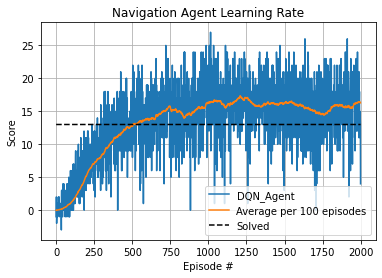

In [12]:
def graph_results(Agents, save_graph=True):
    """ Used to graph the results of agents from simulations

    :param agent_scores: list of Agents you want to graph results from
    :param save_graph: bool used to save the graph in images
    """
    # Load scores for given Agents
    agent_scores = []
    for agent in Agents:
        with open(f"C:\Dev\Python\RL\\Navigation_Project\p1_navigation\saved_scores\\{agent}.txt", 'r') as f:
            scores = f.read().splitlines()
            scores = [float(score) for score in scores]
            agent_scores.append((str(agent), scores))

    # Setup up graph
    fig, ax = plt.subplots()
    ax.set(xlabel="Episode #", ylabel='Score', title="Navigation Agent Learning Rate")
    ax.grid()
    save_name = ""
    # Graph all the results
    for name, score in agent_scores:
        #Plot Scores
        ax.plot(np.arange(len(score)), score, label=f"{name}")
        save_name += f"{name}_"
        # Plot rolling average
        rolling_average = np.convolve(score, np.ones(100)/100)
        rolling_average = rolling_average[:-100] #Removes tail that is window_size < 100
        ax.plot(np.arange(len(rolling_average)), rolling_average, label="Average per 100 episodes")
    # Plot solved line
    ax.plot(np.arange(len(agent_scores[0][1])), np.ones(len(agent_scores[0][1]))*13, color='black', linestyle='dashed', label="Solved")
    ax.legend()

    if save_graph:
        filepath = f"C:\Dev\Python\RL\\Navigation_Project\p1_navigation\images\\{save_name}.png"
        fig.savefig(filepath)
    plt.show()

graph_results([dqn_agent])